<a href="https://colab.research.google.com/github/AjayDXavier/Machine-learning/blob/main/Enhanced_QoL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧠 Enhanced QoL Classification with Machine Learning

This notebook builds a predictive model for classifying Quality of Life (QoL) using medical, lifestyle, and demographic data. We use feature engineering, ensemble methods, and model evaluation to improve prediction accuracy.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Load data
df = pd.read_csv('MLDATA.csv')

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace('[^a-z0-9]', '_', regex=True)

# Gender encoding
df['gender'] = df['gender'].astype(str).str.strip().str.lower().map({'male': 0, 'female': 1})

# Binary columns
binary_cols = ['panicattackhistory_yes_no_', 'hypertensionhistory_yes_no_',
               'medicationuse_yes_no_', 'smoking_alcohol_etc_yes_no_']
for col in binary_cols:
    df[col] = df[col].astype(str).str.strip().str.upper().map({'YES': 1, 'NO': 0})

# Categorical ordinal column
df['socialinteraction_low_med_high_'] = df['socialinteraction_low_med_high_'].astype(str).str.strip().str.upper().map({'LOW': 0, 'MED': 1, 'HIGH': 2})

# Extract numeric duration
if 'duration' in df.columns:
    df['duration'] = df['duration'].astype(str).str.extract(r'(\d+)').astype(float)


In [ ]:

# Compute QoL score
df['qol_score'] = (
    100
    - df['painseverity_1_10_'] * 3
    - df['anxietyscore'] * 2
    - df['depressionscore'] * 2
    - df['panicattackhistory_yes_no_'] * 10
    - df['hypertensionhistory_yes_no_'] * 5
    - df['medicationuse_yes_no_'] * 5
    - df['smoking_alcohol_etc_yes_no_'] * 5
    + df['sleephours'] * 2
    + df['physicalactivity_hoursperweek_'] * 2
    + df['socialinteraction_low_med_high_'] * 5
    - df['age'] * 0.1
)

# QoL classification
def classify_qol(score):
    if score < 40:
        return 'Low'
    elif score < 70:
        return 'Medium'
    else:
        return 'High'

df['qol_class'] = df['qol_score'].apply(classify_qol)


In [ ]:

cat_cols = ['location', 'trigger', 'occupation']
cat_cols = [col for col in cat_cols if col in df.columns]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [ ]:

X = df.drop(['qol_score', 'qol_class'], axis=1)
y = df['qol_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=20)


In [ ]:

# Classifiers
rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Ensemble
voting = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('gb', gb)
], voting='soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)


📊 Accuracy: 0.63

📋 Classification Report:

              precision    recall  f1-score   support

        High       0.75      0.71      0.73        34
         Low       0.58      0.65      0.61        17
      Medium       0.53      0.53      0.53        30

    accuracy                           0.63        81
   macro avg       0.62      0.63      0.62        81
weighted avg       0.63      0.63      0.63        81



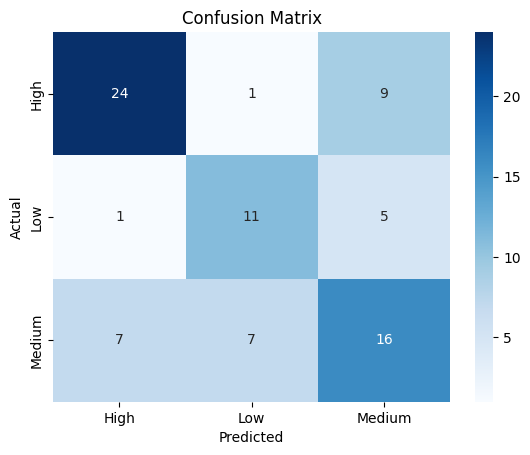

In [ ]:

print("📊 Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=voting.classes_, yticklabels=voting.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Assuming X and y_cls are defined
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_cls)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_cls.iloc[train_idx], y_cls.iloc[test_idx]

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold+1} Accuracy: {round(acc, 3)}")

print("\n📊 Average Accuracy across 5 folds:", round(np.mean(accuracies), 3))
print("\n📋 Overall Classification Report:")
print(classification_report(all_y_true, all_y_pred))


NameError: name 'y_cls' is not defined